# Dry Weather Flow Analysis


In this post, I am going to show how I can use python to create my diurnal flow patterns. For most people, you might use excel or modeling tool to get this done.

This is an area I strongly believe python really shines. The real world is a complicated and messy place, dry weather diurnal pattern is something we can observe, but we know very little what controls the shape and timing of a diurnal pattern. From my own experiences, people kind of just do it because it has been done this way all the time without asking questions why does it look like this, how do I know the pattern I have is good or bad.

I think the approach I will go through below will help more people to start look at modeling, especially calibration from a new angle. I am here to learn, and the flow monitoring data has many answers to my questions, if I know how to use python to ask for it.



The data for this exercise is the [EPA SSOAP](https://www.epa.gov/water-research/sanitary-sewer-overflow-analysis-and-planning-ssoap-toolbox) Example data. 

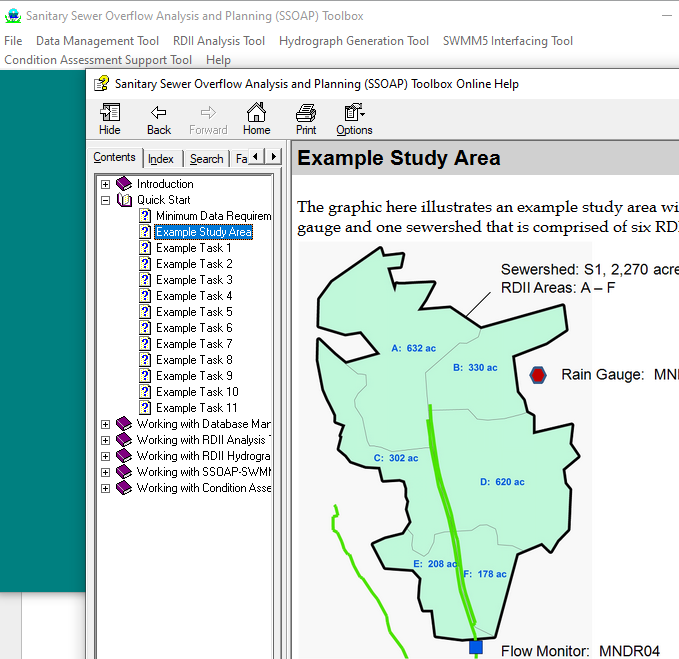

## Read the csv files

Using the code below to read the flow and rainfall data from the csv file.

Both the flow data and rainfall data are 15 min interval, and the rainfall is in total depth format. 

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
def read_flow_csv(f):
    df = pd.read_csv(f)
    df.index = df.apply(lambda x: datetime.datetime(int(x['Year']), int(x['Month']), int(x['Day']), int(x['Hour']), int(x['Minute'])), axis=1)
    
    return df.loc[:, ['Flow_mgd', 'Velocity_fps', 'Depth_in']]


def read_rain_csv(f):
    df = pd.read_csv(f)
    df.index = df.apply(lambda x: datetime.datetime(int(x['Year']), int(x['Month']), int(x['Day']), int(x['Hour']), int(x['Minute'])), axis=1)
    
    return df.loc[:, ['Rain (inch)']]

## Interactively Plot the Data

Using the powerful [plotly](https://plotly.com/python/) libraries, we can create interactive plots fairly easily. You can find more about how to set it up in my [medium post](https://medium.com/@mel.meng.pe/big-data-brings-advanced-graphing-tools-to-everyone-e5734038b604). Below are a few helper functions to plot the data.

Plotly is a game changer, without the interactive chart, working with data in a notebook still feels awkard. But now it can easily beat the latest modeling software functionalities.


In [2]:
import pandas as pd
import csv
import plotly.graph_objects as go

In [3]:
def scatter_plot(df, depth_fld, velocity_fld, depth_unit='in', velocity_unit='fps'):
    # https://github.com/plotly/plotly.py/issues/1445

    df = df.copy()
    df._velocity = df[velocity_fld]
    df._depth = df[depth_fld]
    fig = go.FigureWidget()
    trace1 = fig.add_scattergl(x=df._velocity, y=df._depth, mode='markers', name='points',
                             marker = dict(size=5,
                                           opacity=.5,
                                           color='#1f77b4',
                                           line = dict(width=1, color = '#1f77b4')
                                          )
                            )
    trace2 = fig.add_histogram(x=df._velocity, name='velocity', marker=dict(color='#1f77b4', opacity=0.7),
                          yaxis='y2'
                         )
    trace3 = fig.add_histogram(y=df._depth, name='depth', marker=dict(color='#1f77b4', opacity=0.7), 
                          xaxis='x2'
                         )
    fig.layout = dict(xaxis=dict(domain=[0, 0.85], showgrid=True, zeroline=False, title='Velocity(%s)' % velocity_unit),
                      yaxis=dict(domain=[0, 0.85], showgrid=True, zeroline=False, title='Depth(%s)' % depth_unit),
                      showlegend=False,
                      margin=dict(t=50),
                      hovermode='closest',
                      bargap=0,
                      xaxis2=dict(domain=[0.85, 1], showgrid=False, zeroline=False),
                      yaxis2=dict(domain=[0.85, 1], showgrid=False, zeroline=False),
                      height=600,
                      width=600,
                      title = 'Scatter Plot'
                     )

    def do_zoom(layout, xaxis_range, yaxis_range):
        inds = ((xaxis_range[0] <= flow.df._velocity) & (flow.df._velocity <= xaxis_range[1]) &
                (yaxis_range[0] <= flow.df._depth) & (flow.df._depth <= yaxis_range[1]))

        with fig.batch_update():
            trace2.x = flow.df._velocity[inds]
            trace3.y = flow.df._depth[inds]

    fig.layout.on_change(do_zoom, 'xaxis.range', 'yaxis.range')
    return fig

In [4]:
from plotly.subplots import make_subplots

def flow_plot(flow_df, rain_df, depth_fld, velocity_fld, rainfall_fld, flow_fld, depth_unit='in', 
              rainfall_unit='in/hr', flow_unit='mgd', velocity_unit='fps', start=None, end=None):
    
    rain_df = rain_df.copy()
    flow_df = flow_df.copy()
    if start:
        rain_df = rain_df[start:end]  
        flow_df = flow_df[start:end]
        
    rain_df['_rainfall'] = rain_df[rainfall_fld]
    flow_df['_flow'] = flow_df[flow_fld]
    flow_df['_depth'] = flow_df[depth_fld]
    flow_df['_velocity'] = flow_df[velocity_fld]
    fig = make_subplots(rows=3, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.01,
                       row_heights=[0.2,0.4,0.4],
                       specs=[[{"secondary_y": False}],[{"secondary_y": True}], [{"secondary_y": False}]])

    fig.add_trace(go.Scatter(
        x = rain_df.index,
        y = rain_df['_rainfall'],
        name = 'rainfall',
        line_shape='hv',
        fill='tozeroy',
        line=dict(color='blue', width=1)

    ) , row=1, col=1)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._depth,
        name = 'Depth',
        line=dict(color='blue')
    ) , row=2, col=1)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._velocity,
        name = 'Velocity',
        line=dict(color='green', dash='dot')

    ) , row=2, col=1, secondary_y=True)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._flow,
        name = 'flow',
        line=dict(color='blue')
    ) , row=3, col=1)

    fig['layout']['yaxis1'].update(autorange="reversed", 
                                   title='Rainfall (%s)' % rainfall_fld)

    fig['layout']['yaxis2'].update(title='Depth(%s)' % depth_unit)
    fig['layout']['yaxis3'].update(title='Velocity(%s)' % velocity_unit)
    fig['layout']['yaxis4'].update(title='Flow(%s)' % flow_unit)




    fig.update_layout(
        height = 800, width=1200,
                      title_text="Flow Data Plot",
                     xaxis3_rangeslider_visible=True, 
                      xaxis3_rangeslider_thickness=0.1)
    
    return fig

# The Rainfall and Flow Data

Give it a try, this thing is so good. Very few tools can plot interactive time series chart like this for flow monitoring data.

**You need to change your file paths. They are in the data folder.**

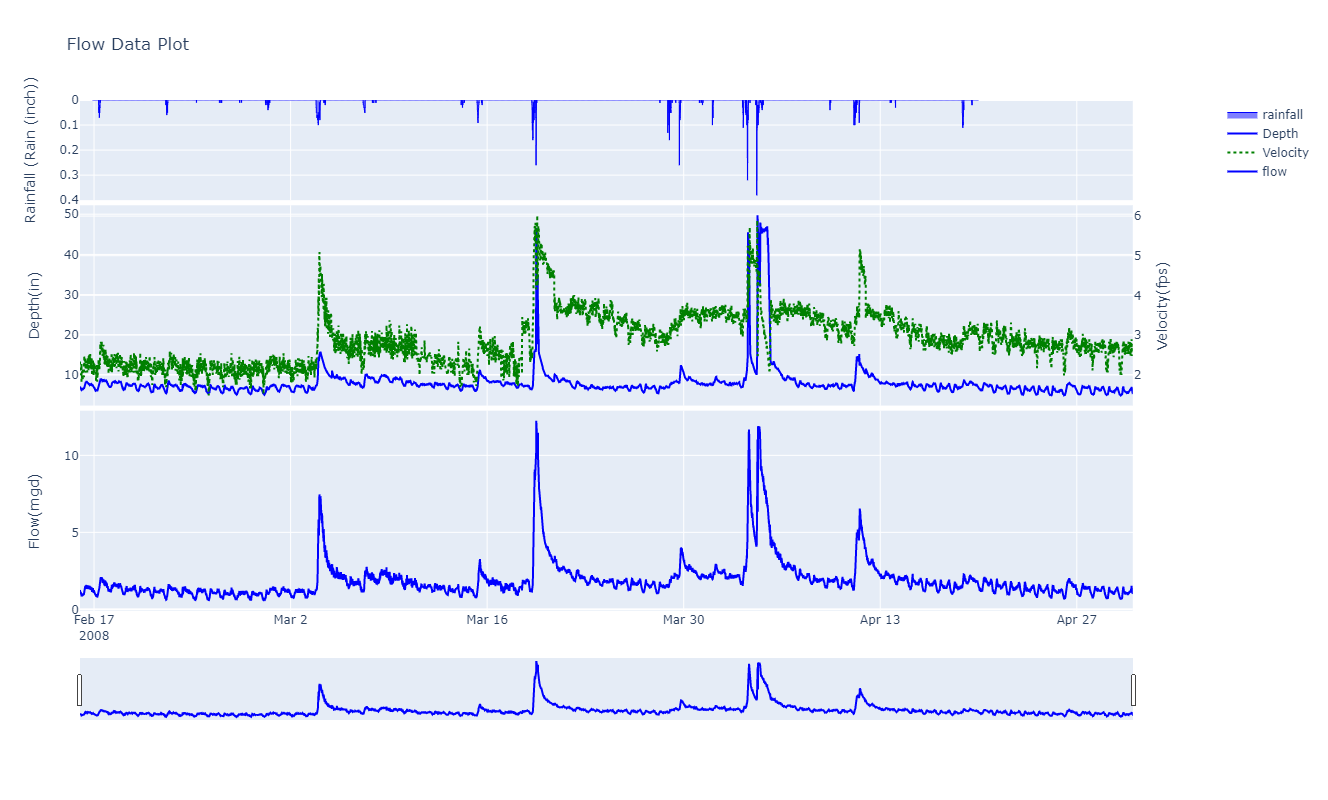

In [8]:
f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\dwf\data\Rain_Gauge.csv"
rain_df = read_rain_csv(f)
f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\dwf\data\Flow_Monitor.csv"
flow_df = read_flow_csv(f)
flow_plot(flow_df, rain_df, depth_fld='Depth_in', velocity_fld='Velocity_fps', rainfall_fld='Rain (inch)', flow_fld='Flow_mgd', depth_unit='in', 
              rainfall_unit='in', flow_unit='mgd', velocity_unit='fps', start=None, end=None)

# Pick Dry Weather Days

When I started modeling, I had the very wrong idea about how things work. I thought modeling work should be done the same way I solve a physics problem, there is only one way to do it using the right equation, no matter who does it, it will give you the same results. 

Pretty quickly, I realized modeling especially sewer modeling with calibration data, is more like walking in a maze. It really doesn't matter that much exactly how you solved it, as long as you can get out that's all that matters. When it comes to modeling nobody knows how the real system works, so it is basically a maze to us, we are all making guesses one way or another.

If you share my view on modeling, you'll understnad my appoach to dry weather analysis. Instead of using the statisical analysis tools like the ones in SSOAP, I'll just eyeball it. Because I know if I got it wrong, I'll have very bad calibration results, and a good calibration is where I want to be, it doesn't matter how I start my guess.

Using the chart above, I got the following days as my dry weather days. 2/19-3/3/2008



# Plot Dry Weather Flow

I first plot the flow data to see if there are strong patterns. For the 13 days I selected, I can see a strong diurnal pattern, but not the same every day.

In [9]:
# need to get the day of the week first for weekday and weekend

df = flow_df.loc[:, ['Flow_mgd']]
df['dt'] = df.index
df['date'] = df['dt'].apply(lambda x: x.strftime('%y-%m-%d'))
df['dow'] = df['dt'].apply(lambda x: x.strftime('%a'))
df['weekend'] = df['dt'].apply(lambda x: x.strftime('%a') in ['Sun', 'Sat'])
df['wkno'] = df['dt'].apply(lambda x: x.strftime('%U'))
df['time'] = df['dt'].apply(lambda x: x.time())
df['hour'] = df['dt'].apply(lambda x: int(x.strftime('%H')))
start='2/19/2008 00:00'
end='3/3/2008 00:00'
df = df[start:end]

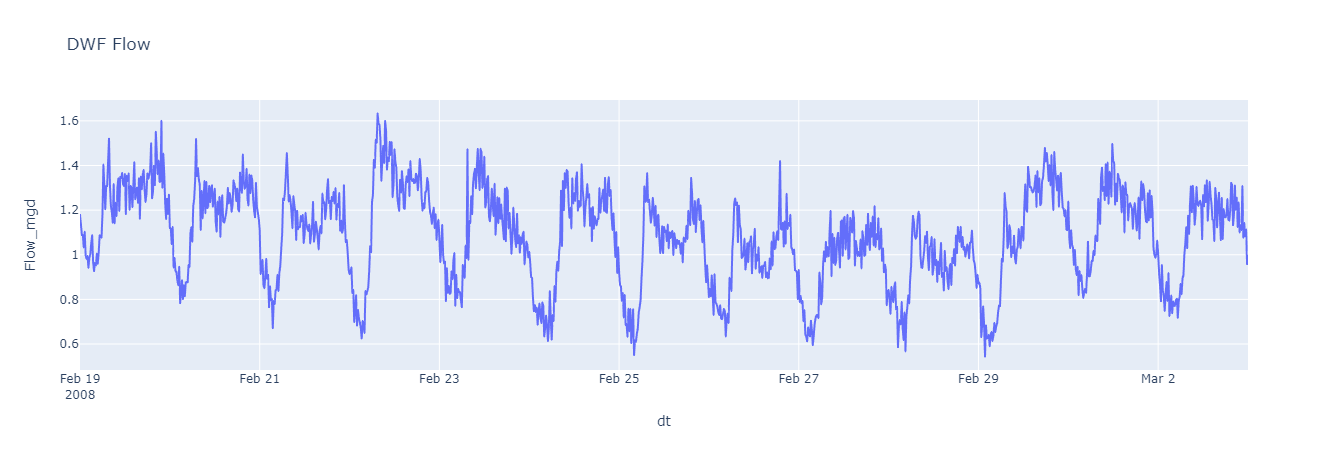

In [10]:
import plotly.express as px
fig = px.line(df, x='dt', y='Flow_mgd', title='DWF Flow')
fig.show()

In [8]:
# Let's what days are weekend
print(df.groupby(['date', 'dow']).count())

              Flow_mgd  dt  weekend  wkno  time  hour
date     dow                                         
08-02-19 Tue        96  96       96    96    96    96
08-02-20 Wed        96  96       96    96    96    96
08-02-21 Thu        96  96       96    96    96    96
08-02-22 Fri        96  96       96    96    96    96
08-02-23 Sat        96  96       96    96    96    96
08-02-24 Sun        96  96       96    96    96    96
08-02-25 Mon        96  96       96    96    96    96
08-02-26 Tue        96  96       96    96    96    96
08-02-27 Wed        96  96       96    96    96    96
08-02-28 Thu        96  96       96    96    96    96
08-02-29 Fri        96  96       96    96    96    96
08-03-01 Sat        96  96       96    96    96    96
08-03-02 Sun        96  96       96    96    96    96
08-03-03 Mon         1   1        1     1     1     1


## Weekday vs Weekend

I generally use only weekday and weekend day hourly patterns for my models. For the purpose of master planning, the goal is not to get the model calibrated as closely as possible.Instead, it is to reasonably represent how the system work on a typical day of the week, it doesn't matter what day it is.

This can be especially true if the flow data doesn't show a very strong repeatable diurnal pattern. So even if I cannot calibrate the results very well, as a modeler I'll need to make the decision what should a typical day look like. And some of the analysis I will do later can help to get some sense what might be happening.

The plot below, shows all the daily flows overlayed by weekday and weekend.

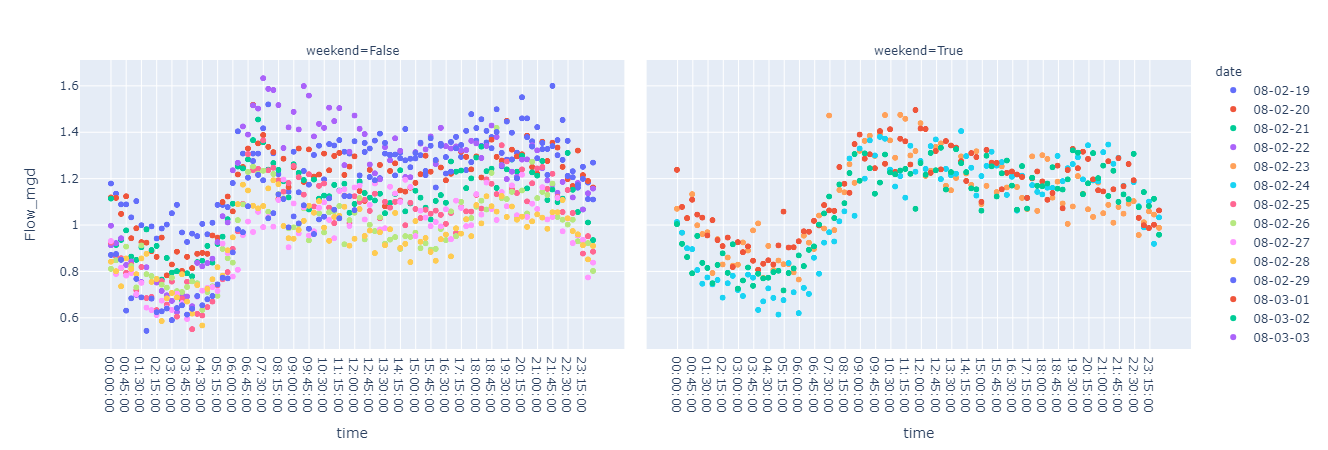

In [11]:
fig = px.scatter(df, x='time', y='Flow_mgd', 
                facet_col='weekend', 
                 color='date', facet_col_wrap=4)
fig.show()

For dirunal patterns, we need to average the data points for each hour. So I'll plot all the readings along the hour on the x-axis.

As show below, for the weekend the band of the data is narrower, while for the weekday, it range is much larger.

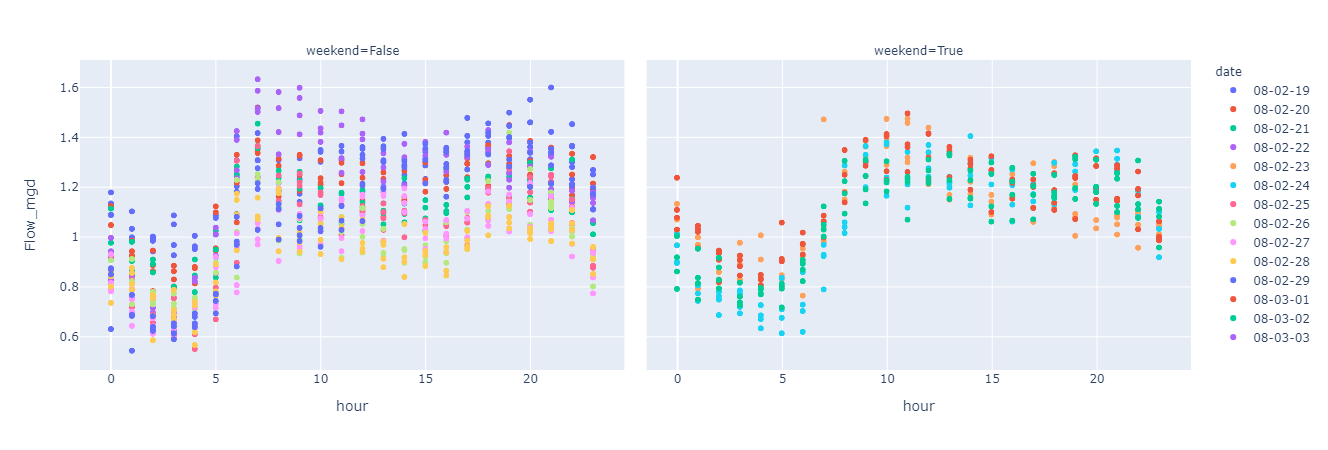

In [15]:
fig = px.scatter(df, x='hour', y='Flow_mgd', 
                facet_col='weekend', 
                 color='date', facet_col_wrap=4)
fig.show()

This is where python really shines, exploratory data analysis!

First, let's try a box plot to get a sense of the data distribution for each hour. You can google and find great explaination of these plots. So it shows the same we observed, the weekend shows a narrow box for most of the hours.

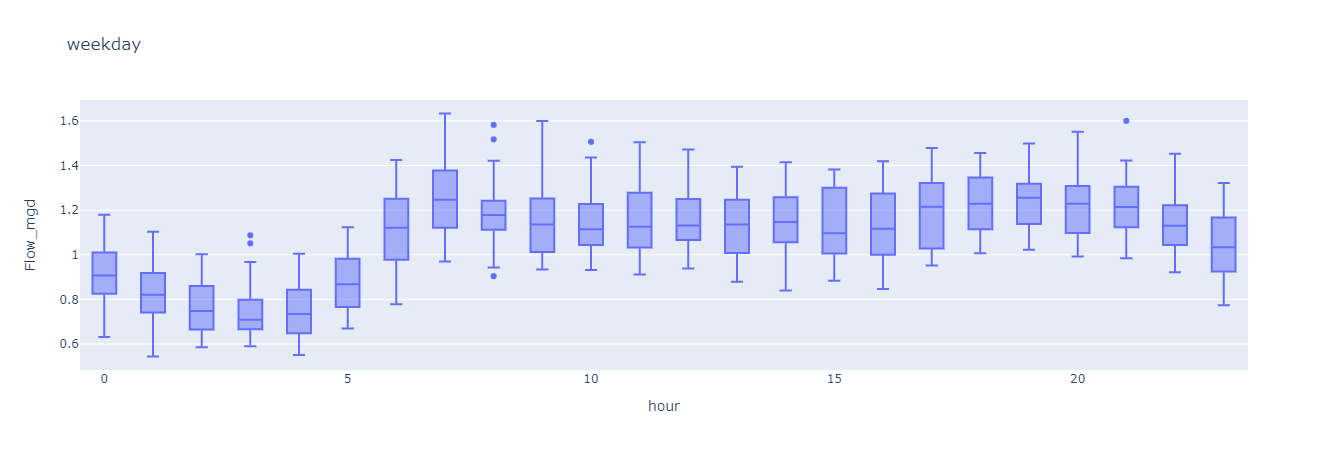

In [17]:
weekday = df[df['weekend']==False]
weekend = df[df['weekend']==True]
px.box(weekday, x = "hour", y = 'Flow_mgd', title='weekday', hover_name = 'hour')

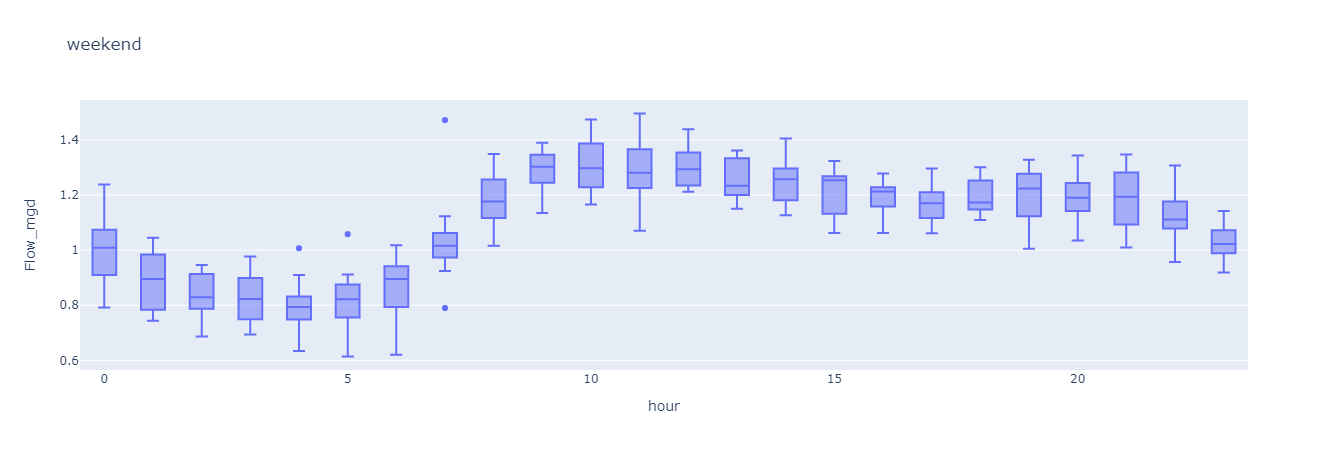

In [18]:
px.box(weekend, x = "hour", y = 'Flow_mgd', title='weekend', hover_name = 'hour')

Seaborn has more plots to choose from, which are not interactive but for what we do they are great.

We can show the standard devation for each hour as the error band, the shaded area around the line, and the line is the average of all the points at the hour.

The major point I want to make is how easy it is to plot these very useful things. I cannot think of another way to get something like this easy.


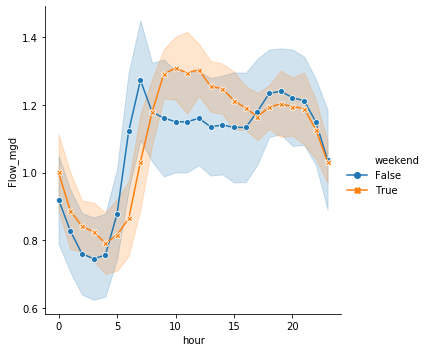

In [20]:
import seaborn as sns
sns.relplot(x="hour", y="Flow_mgd", style="weekend", 
            hue="weekend", ci='sd',
            dashes=False, markers=True, kind="line", data=df);

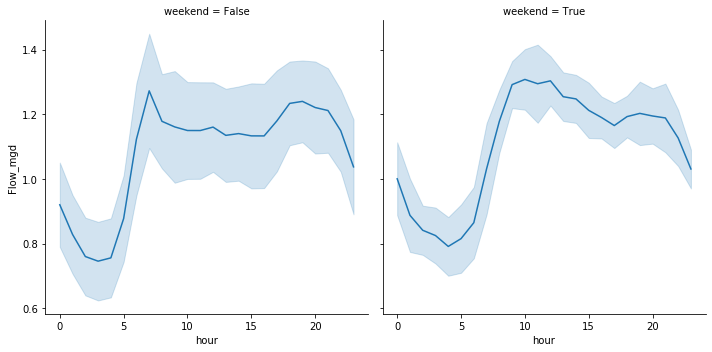

In [21]:
sns.relplot(x="hour", y="Flow_mgd", col="weekend", 
#             hue="weekend", 
            ci='sd',
            dashes=False, markers=True, kind="line", data=df);

## Dive into the data

With the power of these plots at my finger tip, we can afford to ask the question, why we have such big standard deviations.

And with exploratory data analysis, we just need to look at the data from new perspectives. 

Let's look into the data by both week and the day of the week as shown below.

We have roughtly two weeks worth of data, and there are 4 weekend days, and 9 days of weekday days.

- for weekdays, the variation is fairly high, and it seems that the blue dots of week 07 is in general higher than week 08
- For Friday, week 07 has a different pattern 
- for weekend days, the variation is much smaller

Let's dig into each of the items above

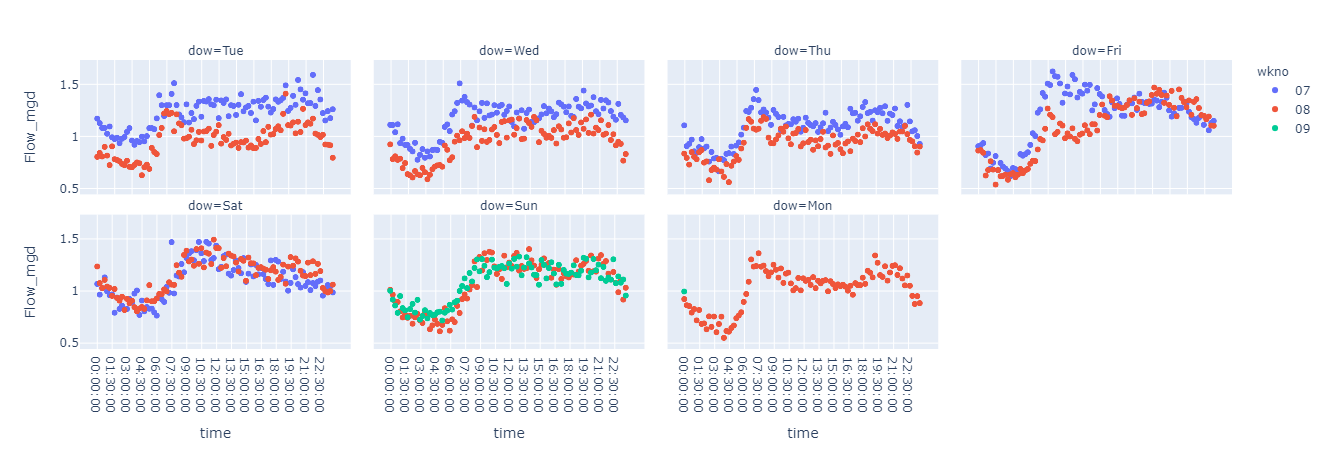

In [22]:
import plotly.express as px
fig = px.scatter(df, x='time', y='Flow_mgd', 
                facet_col='dow', 
                 color='wkno', facet_col_wrap=4)
fig.show()

As shown in the table below, I compared the mean flow of the same day in different weeks using a pivot table.

- For week 09, we have only Sun and Mon (NaN: Not a number for these days)
- For week 07 we don't have Sun and Mon
- As we can see the difference between week 07 and 08 is calculated in column 07-08, and for Tue, Wed they are around 0.2 mgd and for Friday, the difference is 0.15 mgd

Now if we look at the plot above, the numbers make a lot of sense. I suspect the ground water has lots of impact on this flow meter, so it must rained before the start of the data, and that can explain differnce decreases from Tue to Fri as 0.26->0.21->0.15, as the groud water went down. To better define the dirunal pattern, we might want to adjust the ground water infiltration on a daily basis for these days if needed. However, a better approach would be to locate a long dry period without any ground water influence.



In [24]:
# get a talbe of 
# day of week, week 07, week 08
import numpy as np

pt = pd.pivot_table(df, values='Flow_mgd', index=['dow'],
                    columns=['wkno'], aggfunc=np.mean)
pt['07-08'] = pt['07'] - pt['08']
print(pt)

wkno        07        08        09     07-08
dow                                         
Fri   1.202594  1.088698       NaN  0.113896
Mon        NaN  1.017271  0.997000       NaN
Sat   1.107625  1.147615       NaN -0.039990
Sun        NaN  1.068021  1.083062       NaN
Thu   1.101917  0.944042       NaN  0.157875
Tue   1.241156  0.974281       NaN  0.266875
Wed   1.177979  0.961833       NaN  0.216146


# Adjust the ground water infiltration

Let's give it a try and see if that works. Let's adjust week 07's flow data to match week 08 and see how that will match

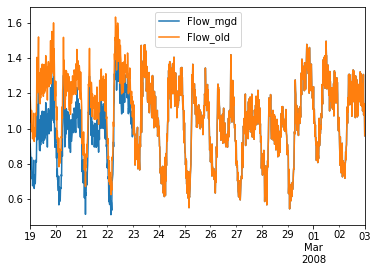

In [25]:
df_gwi = df.copy()
df_gwi['Flow_old'] = df_gwi['Flow_mgd']
filter = (df_gwi['wkno']=='07') & (df_gwi['dow']=='Tue')
df_gwi.loc[filter, 'Flow_mgd'] = df_gwi.loc[filter, 'Flow_mgd'] - 0.266875
filter = (df_gwi['wkno']=='07') & (df_gwi['dow']=='Wed')
df_gwi.loc[filter, 'Flow_mgd'] = df_gwi.loc[filter, 'Flow_mgd'] - 0.216146
filter = (df_gwi['wkno']=='07') & (df_gwi['dow']=='Thu')
df_gwi.loc[filter, 'Flow_mgd'] = df_gwi.loc[filter, 'Flow_mgd'] - 0.157875
filter = (df_gwi['wkno']=='07') & (df_gwi['dow']=='Fri')
df_gwi.loc[filter, 'Flow_mgd'] = df_gwi.loc[filter, 'Flow_mgd'] - 0.113896

df_gwi.loc[:,['Flow_mgd', 'Flow_old']].plot()


Below is the image before the adjustment, and let's compare that with the after adjustment plot. The adjustment made a big difference.

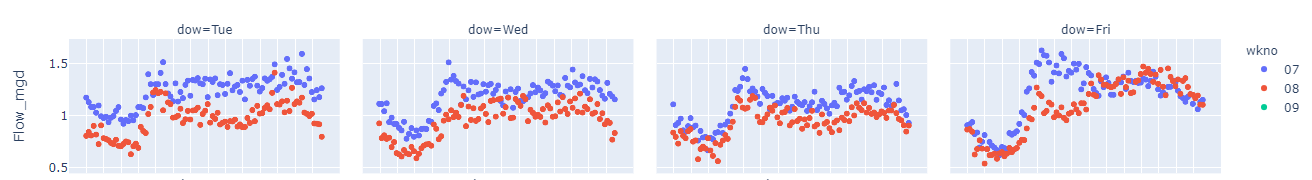

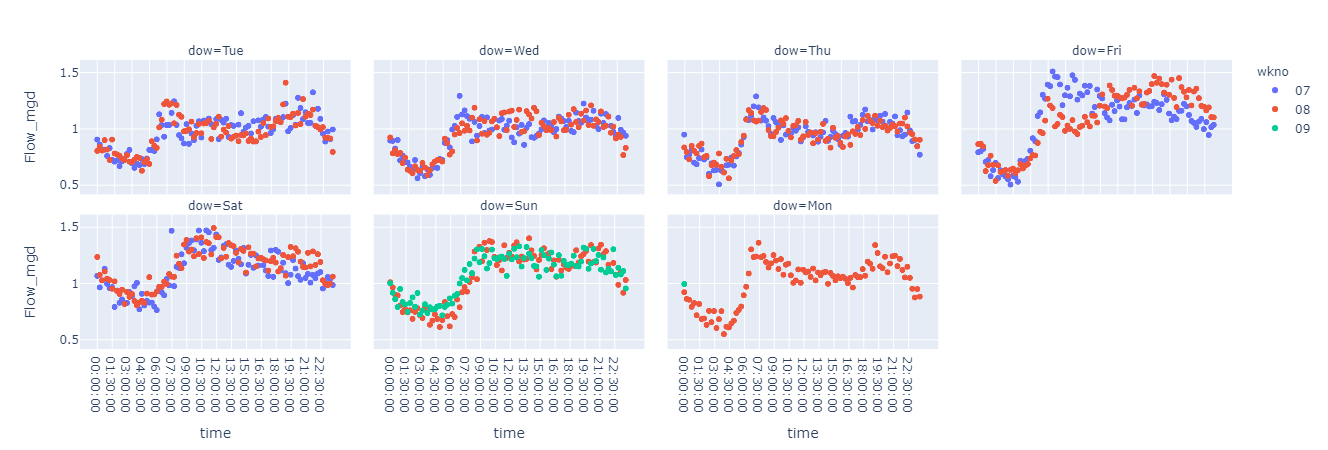

In [26]:
fig = px.scatter(df_gwi, x='time', y='Flow_mgd', 
                facet_col='dow', 
                 color='wkno', facet_col_wrap=4)
fig.show()

# Conclusion

In this post I showed how you can dig really deep into the flow monitoring data using python. I am really shocked at this point, for what I've just did, if you count the lines of code, it is so easy to do! Even a few years ago, even in my wildest dreams, I wouldn't think this is possible.

I hope you are as excited as I am, learn python and all the the tools I used here, it will give you super powers for analyzing flow data.

Below are the code for generating the diurnal patterns for both week and weekend.

          mean       std  median  count
hour                                   
0     0.920108  0.130441  0.9070     37
1     0.828306  0.121652  0.8210     36
2     0.760056  0.120167  0.7475     36
3     0.745722  0.121527  0.7090     36
4     0.755944  0.122143  0.7350     36
5     0.877472  0.133654  0.8680     36
6     1.122750  0.173891  1.1205     36
7     1.272472  0.176576  1.2470     36
8     1.178194  0.145674  1.1785     36
9     1.160917  0.172656  1.1360     36
10    1.149778  0.149736  1.1145     36
11    1.149694  0.149234  1.1260     36
12    1.160333  0.138360  1.1310     36
13    1.134778  0.143987  1.1350     36
14    1.140250  0.145712  1.1465     36
15    1.133194  0.162431  1.0965     36
16    1.133056  0.161309  1.1165     36
17    1.179500  0.156191  1.2155     36
18    1.233583  0.129440  1.2285     36
19    1.239889  0.126469  1.2555     36
20    1.220833  0.142291  1.2285     36
21    1.211583  0.130585  1.2145     36
22    1.149056  0.126759  1.1305     36


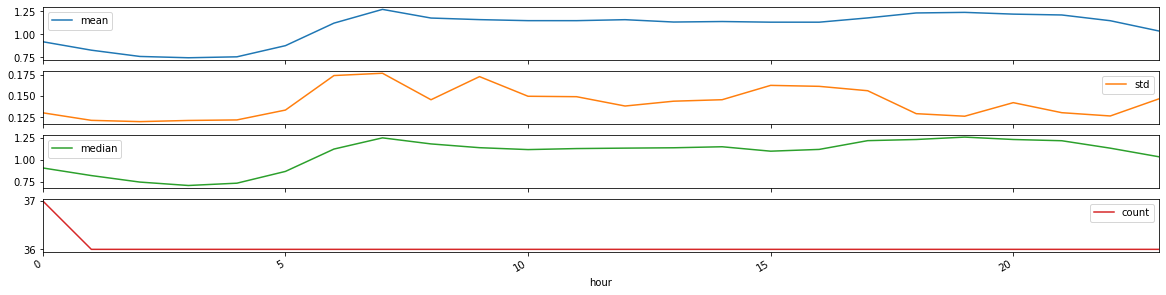

In [27]:
# weekday
import numpy as np
weekday_summary = weekday.groupby(['hour']).agg([np.mean, np.std, np.median, 'count'])['Flow_mgd']
print(weekday_summary)
weekday_summary.plot(subplots=True, figsize=(20, 5));

          mean       std  median  count
hour                                   
0     1.000438  0.112837  1.0085     16
1     0.887500  0.113316  0.8950     16
2     0.841250  0.076025  0.8290     16
3     0.824937  0.086480  0.8230     16
4     0.791313  0.090614  0.7935     16
5     0.815375  0.105603  0.8220     16
6     0.864750  0.110204  0.8950     16
7     1.031313  0.141182  1.0160     16
8     1.178313  0.097300  1.1765     16
9     1.291688  0.072652  1.3025     16
10    1.307750  0.093617  1.2970     16
11    1.294438  0.120758  1.2805     16
12    1.303375  0.076394  1.2935     16
13    1.254375  0.075172  1.2340     16
14    1.247500  0.074320  1.2570     16
15    1.212125  0.085402  1.2540     16
16    1.190000  0.064868  1.2130     16
17    1.165125  0.069595  1.1705     16
18    1.192812  0.064305  1.1730     16
19    1.202750  0.098068  1.2240     16
20    1.194688  0.085575  1.1900     16
21    1.188625  0.106180  1.1940     16
22    1.126750  0.086846  1.1110     16


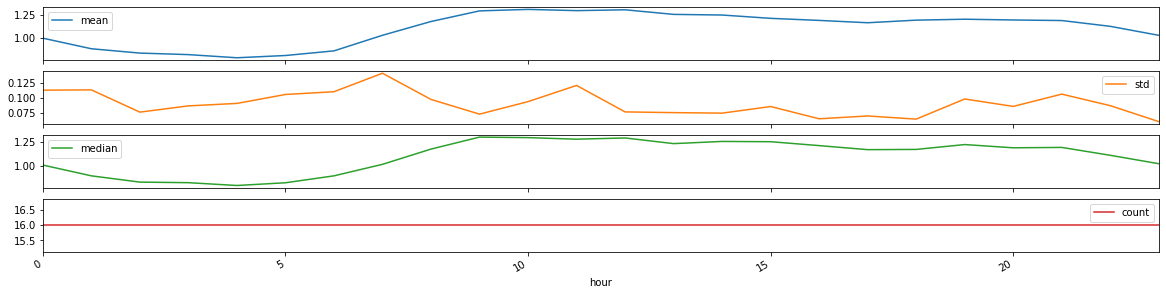

In [28]:
# weekday
import numpy as np
weekend_summary = weekend.groupby(['hour']).agg([np.mean, np.std, np.median, 'count'])['Flow_mgd']
print(weekend_summary)
weekend_summary.plot(subplots=True, figsize=(20, 5));